# 1. Giới thiệu chung

Ở bài này tôi sẽ hướng dẫn các bạn huấn luyện model YOLO trên google colab qua các khâu:

* Cấu hình cài đặt GPU.
* Chuẩn bị dữ liệu.
* Cấu hình mô hình.
* Huấn luyện và dự báo.

Qúa trình huấn luyện YOLO sẽ rất dễ xảy ra lỗi nếu chưa có kinh nghiệm. Chính vì thế tôi sẽ tổng kết các lưu ý quan trọng khi huấn luyện mô hình này trên darknet.

Trước khi đọc bài hướng dẫn mang tính chất thực hành này, tôi khuyến nghị các bạn hãy đọc hiểu lý thuyết mô hình đã được trình bày ở [Bài 25 - YOLO You Only Look Once](https://phamdinhkhanh.github.io/2020/03/09/DarknetAlgorithm.html). Điều này sẽ giúp các trả lời được các câu hỏi **tại sao** về các lỗi của model YOLO khi huấn luyện ở cuối bài viết. Sau khi đã đọc và nắm vững kiến thức ở bài 25, chỉ cần làm theo tuần tự các bước bên dưới là bạn sẽ thu được thành quả.

# 2. Cài đặt cấu hình cuDNN

CUDA Deep Neural Network library (cuDNN) là một thư viện giúp tăng tốc GPU khi huấn luyện các model deep learning. Thư viện này cung cấp quá trình tối ưu huấn luyện feed forward và backpropagation trên các layers: convolution, pooling, normalization, activation. Đây là một thư viện rất mạnh và được hỗ trợ đa dạng trên các deep learning frameworks như:  Caffe,Caffe2, Chainer, Keras,MATLAB, MxNet, TensorFlow, và PyTorch. 

Chúng ta nên sử dụng các thư viện cuDNN mới nhất vì theo như quảng cáo của NVIDIA, nó có thể tăng tốc nhiều lần so với version cũ.

![](https://developer.nvidia.com/sites/default/files/rnn-image_0.png)

Đối với các bạn sử dụng máy tính cá nhân đã có GPU, để sử dụng được GPU thì chúng ta phải cài đặt cuDNN theo [hướng dẫn cài đặt cuDNN - NDIVIA](https://developer.nvidia.com/cudnn).

Các bạn thực hành trên google colab có thể bỏ qua phần này vì google colab đã cài sẵn cuDNN.

# 3. Khởi tạo google colab

## 3.1. Google colab
Google colab là một virtual cloud machine được google cung cấp miễn phí cho các nhà nghiên cứu. Đây là môi trường lý tưởng để phát triển các mô hình vừa và nhỏ với các packages và frame work deep learning và machine learning phổ biến nhất được cài sẵn.

Để sử dụng google colab các bạn vào google drive, sau đó click vào `New > More > Google colab`.

![](https://imgur.com/Xl4qJ0X.png)

Một màn hình google colab hiện ra, có chức năng gần giống như jupyter notebook:

* Chúng ta vừa có thể trình bày văn bản kết hợp với xử lý câu lệnh. Các phần trình bày văn bản được tạo ra từ các block text và xử lý code được tạo ra từ các block codes.

![](https://imgur.com/un5hQdr.png)

* Ngôn ngữ thực thi mặc định của Google colab là python. Ngoài ra bạn có thể thực thi các lệnh command line bằng cách thêm một markup là dấu `!` ở đầu câu lệnh.

Chẳng hạn bên dưới tôi sẽ chạy một vài lệnh trên commandline của ubuntu để kiểm tra version cuda được google cài đặt.

**Command line kiểm tra version cuda:**

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


## 3.2. Enable GPU trên google colab

Mặc định google colab sẽ disable GPU để tiết kiệm tài nguyên. Do đó chúng ta enable bằng cách: Trên thanh công cụ của google colab click vào `Runtime > change runtime type`.


![](https://imgur.com/rtwkCPw.png)

Tại cửa sổ pop-up mục `Hardware accelerator` ta lựa chọn GPU và save.

![](https://imgur.com/tj8SauX.png)


Muốn biết GPU đã enable thành công chưa, ta sử dụng:

**Command line kiểm tra cấu hình GPU**

In [0]:
!nvidia-smi

Sun Mar  8 03:12:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    25W /  75W |    535MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

![](https://imgur.com/rAiiJoU.png)

Như vậy google colab cung cấp 1 GPU Tesla P4 với bộ nhớ 7611MiB. Đây là GPU không quá mạnh nhưng đủ để được để huấn luyện các model deep learning vừa và nhỏ. Phù hợp với các bạn sinh viên và các nhà data scientist nghèo như mình chẳng hạn.

## 3.3. Mount google drive

Google colab có tác dụng như là một VM (virtual machine computing) làm nhiệm vụ tính toán, xử lý dữ liệu. Google Drive là nơi lưu trữ dữ liệu. Do đó để VM truy cập được tới dữ liệu tại Google drive thì ta cần mount drive.

![](https://imgur.com/kpeMAsi.png)


Tại mục này, chúng ta sẽ bắt đầu đi vào thực hành. Để thuận tiện, các bạn có thể download file [darknetGoogleColab.ipynb] trong [phamdinhkhanh - darknetGoogleColab](https://github.com/phamdinhkhanh/darknetGoogleColab.git) và thực hiện các step bắt đầu từ đây.


**Câu lệnh mount google drive:**

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Dòng `Enter your authorization code:`: Yêu cầu chúng ta nhập token để đăng nhập vào VM.

Click vào link `Go to this URL in a browser` để xác thực email. Sau khi accept các bước ta thu được đoạn mã token bên dưới:


![](https://imgur.com/CQEv7NW.png)


Copy token và paste vào dòng `Enter your authorization code:`. Sau bước này chúng ta đã establish một connection từ VM đến Google drive.



# 4. Huấn luyện YOLO trên google colab

## 4.1. Khởi tạo project darknet trên google drive.

[Darknet](https://github.com/AlexeyAB/darknet) là một framework open source chuyên biệt về object detection được viết bằng ngôn ngữ C và CUDA. Các mô hình được huấn luyện trên darknet nhanh, đồng thời darknet dễ cài đặt và hỗ trợ tính toán CPU và GPU. Cộng đồng sử dụng darknet đông đảo, đội ngũ support nhiệt tình. Đó là lý do tôi lựa chọn darknet để hướng dẫn các bạn.

Tại bước này chúng ta cần clone project [darknetGoogleColab](https://github.com/phamdinhkhanh/darknetGoogleColab.git) mà tôi đã customize lại một chút cho phù hợp với google colab. 

Các bạn thực hiện tuần tự như sau:

**Step 1**: Thay đổi đường dẫn tới folder mặc định là `My Drive`.

In [0]:
import os

path = "/content/gdrive/My Drive"
os.chdir(path)

**Step 2:** Sử dụng command line để clone git project `darknetTurtorial` từ github repo của tôi.

In [0]:
!git clone https://github.com/phamdinhkhanh/darknetGoogleColab.git

Cloning into 'darknetGoogleColab'...
remote: Enumerating objects: 430, done.
remote: Counting objects: 100% (430/430), done.
remote: Compressing objects: 100% (321/321), done.
remote: Total 430 (delta 102), reused 430 (delta 102), pack-reused 0
Receiving objects: 100% (430/430), 6.20 MiB | 10.37 MiB/s, done.
Resolving deltas: 100% (102/102), done.
Checking out files: 100% (473/473), done.


Sau khi chạy thành công bạn kiểm tra trên My Drive của Google drive bạn sẽ thấy folder `darknetGoogleColab` vừa mới được clone về.

![](https://imgur.com/AyeE1q0.png)

Sau đó chúng ta cd vào folder và phân quyền execute module darknet để có thể chạy được các lệnh trên darknet.

In [0]:
%cd darknetGoogleColab

!ls

# phân quyền execute module darknet
!chmod +x ./darknet

Lúc này chúng ta đã có thể sử dụng được các lệnh của dự báo, huấn luyện của darknet trên hệ điều hành ubuntu.

## 4.2. Chuẩn bị dữ liệu

### 4.2.1. Tool bounding box

Hiện tại có rất nhiều các open source bounding box tool khác nhau được sử dụng để gán nhãn cho mô hình YOLO. Với kinh nghiệm trải nghiệm các tool này, tôi khuyến nghị các bạn sử dụng [labelImg](https://pypi.org/project/labelImg/) của pypi vì những lý do sau:

![](https://raw.githubusercontent.com/phamdinhkhanh/BBox-Tool/master/labelImage.jpg)


* Giao diện UI/UX khá tốt với đầy đủ chức năng: open, load, save,....
* Hỗ trợ gán nhãn trên cả 2 định dạng COCO xml format và YOLO default txt format.
* Chức năng default bounding box cho phép tự động gán nhãn cho các bức ảnh nằm chung trong một folder. Ví dụ: Khi gán nhãn cho sản phẩm cafe thì các bức ảnh của tôi về cafe đều được xếp về chung 1 folder. Tôi không cần phải gõ lại nhãn mà chỉ cần tạo một default bounding box cho toàn bộ ảnh.

Và rất nhiều các chức năng khác.

Việc cài đặt và hướng dẫn sử dụng các bạn đọc tại [labelImg](https://pypi.org/project/labelImg/).

Khi huấn luyện model YOLO trên darknet. Chúng ta sẽ cần sử dụng đầu vào là các bức ảnh (có thể là một trong các định dạng png, jpg, jpeg) và annotation của chúng (định dạng txt). Bên dưới là nội dung của một file annotation.txt. 

![](https://imgur.com/66Lvm3R.png)

Nội dung của file annotation sẽ bao gồm:

`<id-class> <center-x> <center-y> <bbox-width> <bbox-height>`

Trong đó: các giá trị `<center-x> <center-y> <bbox-width> <bbox-height>` là tâm và kích thước width, height của bounding box đã được chuẩn hóa bằng cách chia cho width và height của ảnh. Do đó các giá trị ngày luôn nằm trong khoảng [0, 1]. `<id-class>` là giá trị index đánh dấu các classes.

Trong trường hợp một ảnh có nhiều bounding box thì mỗi một bounding box sẽ được thể hiện bởi một dòng.

Cảc ảnh và annotation phải được để chung trong cùng 1 folder. Bạn đọc có thể tham khảo qua dữ liệu mẫu [Dữ liệu ảnh sản phẩm TMDT](https://github.com/phamdinhkhanh/VinIDProductObjectDetection/tree/master/img).


### 4.2.2. Dữ liệu thực hành

Trong hướng dẫn này chúng ta cùng xây dựng một mô hình nhận diện sản phẩm thương mại điện tử gồm 5 nhóm mặt hàng: `bia, cafe, mytom, nuoctuong, sua`. Để không mất thời gian cho khâu chuẩn bị dữ liệu thì các bạn có thể clone dữ liệu từ git repo của tôi:

In [0]:
!git clone https://github.com/phamdinhkhanh/VinIDProductObjectDetection.git traindata

Cloning into 'data'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (325/325), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 325 (delta 2), reused 324 (delta 1), pack-reused 0
Receiving objects: 100% (325/325), 12.15 MiB | 15.99 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (216/216), done.


Lệnh trên sẽ clone dữ liệu về folder `traindata` trong project của chúng ta. 

Lưu ý: Không được đặt tên folder `traindata` trùng với folder `data` mặc định của darknet. Nếu không sẽ xảy ra lỗi `Cannot load image` khi dự báo và nhãn dự báo của hình ảnh không hiển thị.

Dữ liệu trong folder img sẽ bao gồm các file ảnh và file annotation (có đuôi .txt) của chúng.

![](https://imgur.com/m477lgr.png)

file ảnh và annotation phải cùng tên để darknet có thể matching tương ứng tên ảnh và nhãn trong quá trình huấn luyện.

### 4.2.3. Phân chia dữ liệu train/validation

Ở bước này ta sẽ tạo ra 2 file train.txt và valid.txt chứa dữ liệu đường dẫn tới các file hình ảnh nằm trong tập train và validation. Chúng ta sẽ sử dụng đoạn code bên dưới để lựa chọn ra ngẫu nhiên 20 files làm dữ liệu validation và các files còn lại làm dữ liệu train.

In [0]:
import glob2
import numpy as np

all_files = []
for ext in ["*.png", "*.jpeg", "*.jpg"]:
  images = glob2.glob(os.path.join("traindata/img/", ext))
  all_files += images

rand_idx = np.random.randint(0, len(all_files), 20)

# Create train.txt
with open("train.txt", "w") as f:
  for idx in np.arange(len(all_files)):
    # if idx not in rand_idx:
    f.write(all_files[idx]+'\n')

# Create valid.txt
with open("valid.txt", "w") as f:
  for idx in np.arange(len(all_files)):
    if idx in rand_idx:
      f.write(all_files[idx]+'\n')

In [0]:
!ls

3rdparty	CMakeSettings.json	image_yolov3.sh        README.md
appveyor.yml	darknet			include		       scripts
build		DarknetConfig.cmake.in	json_mjpeg_streams.sh  src
build.ps1	darknet.py		LICENSE		       train.txt
build.sh	darknet_video.py	Makefile	       _travis.yml
cfg		data			net_cam_v3.sh	       valid.txt
cmake		_gitignore		obj		       video_v2.sh
CMakeLists.txt	image_yolov2.sh		obj.names	       video_yolov3.sh


## 4.3. Cấu hình darknet

### 4.3.1. Tạo file object name

Đây là files chứa tên các classes mà chúng ta sẽ huấn luyện mô hình. Trên file này, thứ tự các classes name cần phải đặt đúng với index của nó trong các file label của vật thể.

In [0]:
# Create obj.names config file
!echo bia > obj.names
!echo cafe >> obj.names
!echo mytom >> obj.names
!echo nuoctuong >> obj.names
!echo sua >> obj.names

Đoạn code trên sử dụng lệnh `echo` của `bash` để tạo và write nội dung vào file `obj.names`. Sau đó, một file `obj.names` được tạo thành trong project foler. Bạn có thể mở file này ra để kiểm tra nội dung.

### 4.3.2. Tạo file config data

File config data sẽ khai báo một số thông tin như:

* Số lượng classes
* Đường dẫn tới các file train.txt, test.txt
* Đường dẫn tới file obj.names
* Thư mục backup mô hình huấn luyện.

Chạy lệnh bên dưới để tạo file này.

In [0]:
# Config obj.data config file
!echo classes=5 > obj.data
!echo train=train.txt >> obj.data
!echo valid=test.txt >> obj.data
!echo names=obj.names >> obj.data
!echo backup=backup >> obj.data

### 4.3.3. Tạo file config model

Đây là bước quan trọng nhất khi huấn luyện model YOLO. Chúng ta sẽ sử dụng file [yolov3.cfg](https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg) để cấu hình mô hình huấn luyện. Các bạn download file trên về máy và điều chỉnh các dòng:

* Tại các dòng 610, 696, 783: Thay `classes=80` thành `classes=5` là số lượng classes chúng ta huấn luyện.

* Tại các dòng 603, 689, 776: Thay số lượng `filters=255` về `filter=30`. Đây chính là layer cuối cùng của base network. Do đó chúng có output shape thay đổi theo số lượng classes theo đúng công thức của bài trước đó là: `(n_classes + 5)x3 = (5+5)x3 = 30`.

* max_batches: tại dòng 20 là số lượng steps tối đa để huấn luyện models YOLO. Đối với dữ liệu 5 classes chỉ cần điều chỉnh `max_batches=5000` là có thể có nghiệm tốt.

* burn_in: Tại dòng 19 là số lượng steps ban đầu được giữ sao cho learning_rate rất bé. Giá trị này sẽ tăng dần từ 0 đến learning_rate. Sau đó learning_rate sẽ được giữ ổn định. Thực nghiệm cho thấy thiết lập learning_rate bé ở những steps đầu sẽ giúp cho thuật toán hội tụ nhanh hơn. Do số lượng `max_batches` chỉ là 5000 nên cần điều chỉnh giảm `burn_in = 100`.

* steps: Tại dòng 22. Điều chỉnh về `steps=4000,4500`. Đây là các vị trí step mà chúng ta sẽ bắt đầu giảm dần learning_rate vì thuật toán đã đạt tới điểm hội tụ nên không cần thiết lập learning_rate quá cao.

Sau khi thực hiện các thay đổi xong, các bạn save file lại và push lên project `darknetGoogleColab` của google driver.

Trước đó, hãy đổi tên lại thành `yolov3-5c-5000-maxsteps.cfg`
để đánh dấu đây là cấu hình cho yolo version 3 với 5 classes và 5000 bước huấn luyện.

Các file config này đã có sẵn trong github repo của tôi nên bạn có thể download về sử dụng ngay.





In [0]:
os.path.exists("obj.data")
os.path.exists("yolov3-5c-5000-max-steps.cfg")

True

## 4.4. Các hàm phụ trợ

Để thuật lợi cho việc đọc và ghi và hiển thị hình ảnh, tôi sẽ xây dựng các hàm phụ trợ có chức năng như sau:

* `imShow()`: Hiển thị hình ảnh từ một path.

* `upload()`: Upload một file từ local lên google drive.

* `download()`: Download một file từ một path trên mạng.

In [0]:
#download files
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
      
def download(path):
  from google.colab import files
  files.download(path)

## 4.5. Huấn luyện mô hình

### 4.5.1. Download pretrain model

YOLO được huấn luyện trên rất nhiều các model pretrain. Những mô hình này được xây dựng trên các bộ dữ liệu ảnh mẫu lớn như: [COCO](http://cocodataset.org/#home), [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/), [Imagenet](http://image-net.org/download), [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html).

Đây là những bộ dữ liệu có định dạng và format chuẩn, được đảm bảo bởi các tổ chức và viện nghiên cứu lớn trên thế giới nên chúng ta hoàn toàn có thể yên tâm về chất lượng dữ liệu.

List các danh sách model pretrain các bạn có thể theo dõi tại [Darknet YOLO](https://pjreddie.com/darknet/yolo/)


![](https://imgur.com/xJ1d61d.png)


Ở ví dụ thực hành này, chúng ta sẽ sử dụng pretrain model [darknet53.conv.74](https://pjreddie.com/media/files/darknet53.conv.74) dược huấn luyện từ bộ dữ liệu ImageNet. Trước tiên hãy clone file weight về google drive.

In [0]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2020-03-08 07:55:46--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  1.11MB/s    in 1m 45s  

2020-03-08 07:57:32 (1.47 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



### 4.5.2. Backup model

Tạo một folder backup để lưu kết quả huấn luyện sau mỗi 1000 steps. Folder backup này phải trùng với tên với link folder backup đã được khai báo ở step `4.3.3. tạo file config data`.

In [0]:
!mkdir backup

Nếu để 1000 steps mới backup model có thể khá lâu. Để tránh các lỗi phát sinh khi huấn luyện tại 1000 steps đầu tiên, trong project của mình tôi đã điều chỉnh sẵn last model backup sau mỗi 100 steps.

### 4.5.3. Huấn luyện model

Để huấn luyện model ta chỉ cần thực hiện lệnh `detector train`.

Tổng quát cú pháp:

`!./darknet detector train [data config file] [model config file] [pretrain-model weights] -dont_show > [file log saved]`

Trong đó các `[data config file]`, `[model config file]` là những file config. `[pretrain-model weights]` là file model pretrain.

In [0]:
!./darknet detector train obj.data yolov3-5c-5000-max-steps.cfg darknet53.conv.74 -dont_show > yolov3-5c.log

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32 0.639 BF
   1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64 3.407 BF
   2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32 0.379 BF
   3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128 3.407 BF
   6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
   7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
  10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256 3.407 BF
  13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128 0.379 BF
  14 c


Nếu bạn nào gặp lỗi:

`CUDA Error: out of memory: File exists`

Hãy quay trở lại file `yolov3-5c-5000-max-steps.cfg` và điều chỉnh giảm `subdivisions=32`. Sau đó train lại model từ đầu.

Tổng cộng quá trình train hết khoảng `5h` đồng hồ. Nếu bạn muốn ngồi đợi thành quả, hãy kiên nhẫn chờ đợi. Hoặc nếu muốn có ngay thành quả, hãy download file [pretrain nhận diện sản phẩm TMDT của tôi](https://drive.google.com/drive/folders/1Oj7yOMEPG59BRVyA3QjVoHWyzX8lNW-E?usp=sharing).

Một số lưu ý: 

* Đừng quên kiểm tra đường truyền internet thường xuyên. Google Colab sẽ tự động kill các session offline trong vòng 1h. Tức nếu bạn tắt colab hoặc bị disconnect internet thì mọi thứ vẫn tiếp diễn trong 1h và sau đó luồng training sẽ bị kill.

* Google colab đồng thời cho phép độ dài tối đa của một session là 12h. Vì vậy với các bộ dữ liệu lớn thì huấn luyện mô hình object detection trên google colab là một việc bất khả thi.

### 4.5.4. Visualize hàm loss function

Kết quả huấn luyện của mô hình qua từng step sẽ được lưu vào file `yolov3-5c.log`. Chúng ta có thể sử dụng file này để visualize hàm loss function.

Trong git project được customize từ darknet tôi đã code sẵn một file có tác dụng visualize loss function. Ý tưởng xử lý không có gì khó, chúng ta sẽ tìm trong log các dòng có `Average Loss` và trích xuất giá trị loss function và visualize. Bạn đọc có thể mở file ra nghiên cứu.

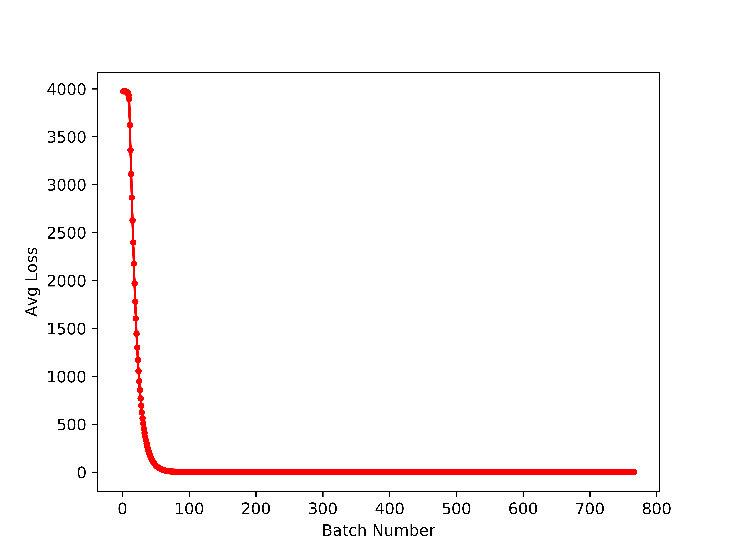

In [0]:
!python3 plotTrainLoss.py yolov3-5c.log
imShow('training_loss_plot.png')

Như vậy đồ thị loss function cho thấy thuật toán đã hội tụ sau khoảng 100 batches đầu tiên. Loss function ở giai đoạn sau có xu hướng tiệm cận 0. Điều này chứng tỏ chiến lược lựa chọn learning_rate nhỏ ở 100 steps đầu tiên đã phát huy hiệu quả giúp thuật toán hội tụ nhanh hơn.

## 4.6. Dự báo

Sau khi huấn luyện xong mô hình, kết quả sau cùng sẽ được lưu trong folder backup

In [0]:
!ls backup

yolov3-5c-5000-max-steps_last.weights


Để dự báo cho một bức ảnh ta sử dụng cú pháp:

`!./darknet detector test [data config file] [model config file] [last-model weights] [image path] -dont_show`

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32 0.639 BF
   1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64 3.407 BF
   2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32 0.379 BF
   3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128 3.407 BF
   6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
   7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
  10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256 3.407 BF
  13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128 0.379 BF
  14 c

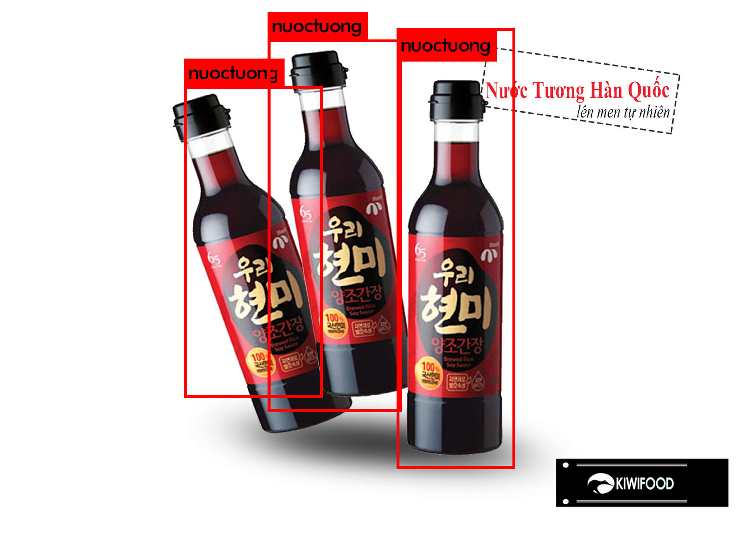

In [0]:
!./darknet detector test obj.data yolov3-5c-5000-max-steps-test.cfg backup/yolov3-5c-5000-max-steps_last.weights traindata/test/nuoctuong3.jpg -dont_show

imShow('predictions.jpg')


Do google colab suppress các hàm graphic của opencv nên ta không thể show image trực tiếp mà phải save kết quả vào file `predictions.jpg`.

argument `-dont_show` để by pass các lỗi graphic của opencv.

Như vậy chúng ta đã hoàn thành quá trình huấn luyện và dự báo một mô hình object detection trên google colab. Cũng không quá khó khăn phải không nào? 

# 5. Ước tính thời gian huấn luyện

Khi hiểu kỹ về lý thuyết của mô hình YOLO các bạn sẽ hiểu lý do tại sao model YOLO lại huấn luyện lâu như vậy. Từ một ảnh đầu vào kích thước `418x418`, YOLO sẽ cần dự đoán nhãn và tọa độ của tổng cộng `(13x13+26x26+52x52)x3 = 10647` bounding boxes. Giả sử mỗi một batch của chúng ta có kích thước 64 ảnh và số lượng `max_batches = 5000`. Như vậy chúng ta cần dự báo cho tổng cộng: `10647x5000x64 = 3.4 triệu` bounding boxes. Đây là một con số không hề nhỏ nên quá trình huấn luyện trên google colab sẽ mất gần `5h`.

Do đó, trước khi huấn luyện chúng ta cần ước lượng tổng thời gian huấn luyện. Tôi sẽ giới thiệu các bạn một số mẹo ước tính và tiết kiệm thời gian huấn luyện.

* Nên ước tính thời gian huấn luyện của 1 batch. Nếu bạn huấn luyện một batch hết 3.6s. Như vậy 5000 batches sẽ tiêu tốn của bạn khoảng: `(3.6x5000)/3600 = 5 h` huấn luyện. Tất nhiên đây chỉ là ước tính tương đối vì không phải mọi batch đều được huấn luyện với thời gian bằng nhau. Nếu gặp những batch có hình ảnh lỗi, format không tương thích thì có thể tốn rất nhiều thời gian để chương trình gỡ lỗi.

* Hãy save log trong quá trình huấn luyện và vẽ biểu đồ loss function. Biểu đồ loss function cho ta biết quá trình huấn luyện đã đi tới trạng thái hội tụ hay chưa? Có thể dừng sớm quá trình huấn luyện nếu bạn quan sát thấy loss function dường như đã hội tụ.

* Huấn luyện trên nhiều GPU song song (cách này không áp dụng được trên google colab). Khi huấn luyện trên nhiều GPU thì nên giảm learning_rate xuống theo cấp số nhân. Chẳng hạn bạn huấn luyện trên 4 GPU thì cần thiết lập learning_rate mới bằng 1/4 learning_rate mặc định trên 1 GPU. Quá trình huấn luyện sẽ nhanh hơn rất nhiều.

* Sử dụng pretrain model trên bộ dữ liệu gần giống với bộ dữ liệu đang huấn luyện. Khi đó các trọng số của mô hình pretrain và mô hình tối ưu cho bộ dữ liệu sẽ gần sát nhau. Chúng ta sẽ chỉ cần ít steps huấn luyện hơn để đạt kết quả tốt so với lựa chọn pretrain model được huấn luyện từ một bộ dữ liệu khác biệt lớn.

* Update cuDNN version. Như đã giới thiệu ở mục 1 cấu hình cuDNN. Những kiến trúc cuDNN mới đã được tối ưu hơn rất nhiều giúp tăng tốc quá trình huấn luyện. Sử dụng cuDNN version 7.6 có thể tăng tốc gấp 2 lần so với version 6.0. Do đó hãy cập nhật cuDNN nếu bạn đang sử dụng version cũ. Nhưng lưu ý là cuDNN cần tương thích version với CUDA để tránh các lỗi phát sinh nhé.

* Cân nhắc sử dụng kiến trúc đơn giản. Các kiến trúc của YOLO khác đa dạng tùy thuộc vào base network. Các bạn xem lại bài giới thiệu về YOLO để hiểu rõ hơn kiến trúc này. Nếu một số tác vụ với ít classes thì chênh lệch về độ chính xác giữa mô hình kiến trúc phức tạp và đơn giản sẽ không quá lớn. Bạn có thể đặt ra trước cho mình một tiêu chuẩn về mAP của mô hình và huấn luyện thử với các model có kiến trúc đơn giản như tiny YOLO. Có thể những mô hình này đã đạt được tiêu chuẩn. Hơn nữa tốc độ dự báo nhanh và có thể triển khai trên các thiết bị IoT cấu hình thấp là một trong những điểm cộng cho các mô hình như vậy. Simple is the best!



# 6. Các lưu ý khi huấn luyện mô hình

Các lưu ý khi huấn luyện model darknet

* Đặt đúng đường link config data: Trong data file chúng ta khai báo các đường dẫn tới các file cấu hình. Các đường dẫn này nếu là địa chỉ tương đối phải được cấu hình theo vị trí mà chúng ta run model để có thể truy cập được. Nội dung của những file này như sau:
  * Files train.txt và text.txt: Đây là những files chứa đường link tới ảnh. Mô hình sẽ load các ảnh từ những đường links này để huấn luyện và kiểm định. Do đó các đường links trong 2 files nên được để là đường link tuyệt đối để không gặp lỗi khi chuyển folders.
  * File obj.names: File chứa tên của các classes. Thứ tự của tên từ trên xuống dưới phải được đặt đúng với thứ tự index của classes được khai báo trong các file annotation của ảnh (element đầu tiên của các file`[image_id].txt`).
  * Folder backup: Là folder được sử dụng để backup kết quả của quá trình huấn luyện. Sau mỗi 1000 batches thì model sẽ được backup một bản tại đây. Đường dẫn này nên được để theo vị trí tuyệt đối để tránh các lỗi phát sinh.

* Cấu hình model YOLO:
  * Thay đổi `classes`: Tất cả các tham số `classes` phải được đưa về đúng bằng số lượng `classes` của dữ liệu chúng ta đang huấn luyện. Mặc định của những file cấu hình đang để là 80 chính là số lượng classes của COCO dataset.
  * Thay đổi `filters` ở layers cuối cùng: Các filters của layer cuối cùng phải được điều chỉnh theo số lượng classes theo công thức `(num_classes+5)x3`. Trong đó `num_classes` là kích thước của véc tơ phân phối xác suất toàn bộ classes đầu ra và 5 là số lượng các tham số bao gồm 4 tham số của tọa độ `<bbox-x-ratio> <bbox-y-ratio> <bbox-width-ratio> <bbox-height-ratio>` và 1 tham số $p_x$ dự báo xác suất có vật thể trong anchor box hay không. 3 chính là số lượng các anchors.

* Thay đổi tham số huấn luyện model: 
  * Số lượng batches huấn luyện: Đối với bộ dữ liệu có số lượng classes lớn (khoảng vài chục classes) thì số lượng batches huấn luyện (tham số `max_batches`) ít nhất khoảng 50000 là có thể đạt được kết quả tốt. Đối với bộ dữ liệu có số lượng classes nhỏ (<5 classes) thì `max_batches` chỉ cần khoảng 4000 đã có thể thu được kết quả tốt. Qúa trình huấn luyện này tốn khá nhiều thời gian. Đối với 50000 batches với kích thước batch_size = 16 có thể tốn 2-3 ngày huấn luyện trên 1 GPU.
  * Mini-batch phải fit với RAM: Tham số `subdivisions` sẽ khai báo số lượng các mini-batch được chia ra từ 1 batch để đưa vào mô hình huấn luyện. Nếu `batch_size = 64, subdivisions = 8` thì kích thước của `mini-batch = batch_size/8 = 8` ảnh. Số lượng các khung hình được sinh ra từ một ảnh là rất lớn nên dù chỉ 8 ảnh cũng có thể vượt quá kích thước RAM. Đối với cấu hình của google colab kích thước 12GB RAM thì chúng ta có thể fit được 4 ảnh.
  *  Cấu hình tham số huấn luyện: Qúa trình huấn luyện các mạng neural cho thấy các steps đầu tiên nên dược thiết lập với learning rate rất nhỏ để mô hình không step khỏi global optimal. Do đó tham số `burn_in=1000` cho phép learning rate của chúng ta tăng dần từ 0 tới `learning_rate` trong 1000 steps đầu tiên. Sau đó `learning_rate` sẽ được giữ nguyên. Và đến các batch ở vị trí gần cuối như `80%` hoặc `90%` thì chúng ta sẽ giảm `learning_rate` xuống với tốc độ giảm là 10 lần. Ở những vị trí này model gần đạt tới global optimal nên không cần phải giữ `learning_rate` quá cao.

* Nên backup lại log của quá trình huấn luyện: quá trình huấn luyện nên được backup lại trên một file log để có thể visualize sau huấn luyện loss function. Những đồ thị này sẽ giúp ích cho chúng ta tìm kiếm các tham số schedule learning tối ưu cho những đợt huấn luyện sau. 

* Lỗi `Unable to init server: Could not connect: Connection refused`: Đây là lỗi xuất hiện khi huấn luyện trên google colab. Lỗi liên quan tới việc sử dụng GUI của `opencv`. Google colab đã disable chức năng của GUI khiến cho code bị dừng. Chúng ta có thể chuyển tiếp lỗi này bằng cách pass thêm argument `-dont_show`.

# 7. Tổng kết

Như vậy tôi đã giới thiệu đến các bạn các bước chi tiết để huấn luyện một mô hình YOLO trên project darknet. Việc huấn luyện mô hình sẽ đòi hỏi các bạn phải có máy tính cấu hình cao, có hỗ trợ GPU. Tuy nhiên với các bạn sinh viên nghèo vượt khó hoặc sinh viên giàu nhưng tiết kiệm có thể áp dụng hướng dẫn này để tự huấn luyện model mô hình cho các tác vụ object detection của mình trên google colab mà không cần phải lo lắng.

Code của project này đã được tổng hợp trên git repo [darknetGoogleColab](https://github.com/phamdinhkhanh/darknetGoogleColab). Các bạn có thể download về, tìm đến file darknetGoogleColab.ipynb, sau đó upload lên google drive và thực hành theo tuần tự các bước. Các lỗi phát sinh đã được note khá chi tiết ở mục Các lưu ý khi huấn luyện mô hình.

# 8. Tài liệu tham khảo

1. [phamdinhkhanh - darknet git repo](https://github.com/phamdinhkhanh/darknetGoogleColab)
2. [Bài 25 - YOLO You Only Look Once - Khanh blog](https://phamdinhkhanh.github.io/2020/03/09/DarknetAlgorithm.html)
3. [pjreddie - darknet git repo](https://github.com/pjreddie/darknet)
4. [AlexeyAB - darknet git repo](https://github.com/AlexeyAB/darknet)


In [0]:
# https://github.com/alankbi/detecto

# https://github.com/davidsandberg/facenet

# https://arxiv.org/pdf/1503.03832.pdf

In [0]:
# !cp "/content/gdrive/My Drive/Colab Notebooks/darknet/darknet53.conv.74" .